In [2]:
from lrfhss.run import *
import time
from joblib import Parallel, delayed
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import pickle
import pandas as pd
import scienceplots
from matplotlib.ticker import EngFormatter
from lrfhss.traffic import *

# Simulations

In [ ]:
#Number of different number of nodes points (each simulation takes one different)
nNodes_points = 20
#Mininum amount of nodes
nNodes_min = 1000
#Maximum amount of nodes
nNodes_max = 100_000
#Number of nodes is divided by 8, as we are simulating one of the 8 grid.
#As they are random selected, it is a very good approximation to consider one of them only, and it decreases the simulation time.
#In the end, we multiply this array by 8 if we want to consider the technology total capacity.
nNodes = np.linspace(nNodes_min, nNodes_max, nNodes_points, dtype=int)//8
#nNodes = np.array([5000, 10000, 20000])//8
#Number of simulation loops for each configuration.
loops = 1000
jobs = 10
hours = 24
df = pd.DataFrame(columns=['Success','Success_ACRDA','Success_std', 'Goodput','Throughput', 'Throughput_std', 'Traffic'])

start = time.perf_counter()
success_exp = []
success_exp_ACRDA = []
success_exp_std = []
goodput_exp = []
throughput_exp = []
throughput_exp_std = []
success_unif = []
success_unif_std = []
goodput_unif = []
throughput_unif = []
throughput_unif_std = []
success_markov = []
success_markov_ACRDA = []
success_markov_std = []
goodput_markov = []
throughput_markov = []
throughput_markov_std = []
#For each number of nodes point, run the simulation "loops" times
for n in nNodes:
    print(f'Nodes: {n*8}')
    ####Exponential Traffic####
    print(f'Start Exponential')
    #For each nNodes, create a new settings object with the proper input parameter
    s = Settings(simulation_time=60*60*hours, payload_size=20, number_nodes=n, traffic_class==Exponential_Traffic, traffic_param={'average_interval': 900})
    #This line runs the simulation loops in paralel, using n_jobs as the number of threads generated.
    #Consider using a number according to the amount of reseources available to your machine to avoid crashing your system.
    results = Parallel(n_jobs=jobs) (delayed(run_sim)(s, seed = seed) for seed in range(0,loops))

    success_exp.append(np.mean(results,0)[0][0])
    success_exp_std.append(np.std(results,0)[0][0])
    goodput_exp.append(np.mean(results,0)[1][0])
    throughput_exp.append(np.mean(results,0)[2][0])
    throughput_exp_std.append(np.std(results,0)[2][0])
    s = Settings(simulation_time=60*60*hours, payload_size=20, base='acrda', number_nodes=n, traffic_class=Exponential_Traffic, traffic_param={'average_interval': 900})
    results = Parallel(n_jobs=jobs) (delayed(run_sim)(s, seed = seed) for seed in range(0,loops))
    success_exp_ACRDA.append(np.mean(results,0)[0][0])

    ####Uniform Traffic####
    print(f'Start Uniform')

    s = Settings(simulation_time=60*60*hours, payload_size=20, number_nodes=n, traffic_class=Uniform_Traffic, traffic_param={'max_interval': 1800})
    results = Parallel(n_jobs=jobs) (delayed(run_sim)(s, seed = seed) for seed in range(0,loops))

    success_unif.append(np.mean(results,0)[0][0])
    success_unif_std.append(np.std(results,0)[0][0])
    goodput_unif.append(np.mean(results,0)[1][0])
    throughput_unif.append(np.mean(results,0)[2][0])
    throughput_unif_std.append(np.std(results,0)[2][0])


    ####Markov Traffic####
    print(f'Start Markov')

    #Markov parameters
    p = 0.99998
    q = 0.15
    pi_2 = (p-1)/(p-q-1)
    markov_time = pi_2*900
    transition_matrix = [[p, 1-p],[q, 1-q]]

    s = Settings(simulation_time=60*60*hours, payload_size=20, number_nodes=n, traffic_class=Two_State_Markovian_Traffic, traffic_param={'transition_matrix': transition_matrix, 'markov_time': markov_time})

    results = Parallel(n_jobs=jobs) (delayed(run_sim)(s, seed = seed) for seed in range(0,loops))
    
    success_markov.append(np.mean(results,0)[0][0])
    success_markov_std.append(np.std(results,0)[0][0])
    goodput_markov.append(np.mean(results,0)[1][0])
    throughput_markov.append(np.mean(results,0)[2][0])
    throughput_markov_std.append(np.std(results,0)[2][0])

    s = Settings(simulation_time=60*60*hours, payload_size=20, base='acrda',number_nodes=n, traffic_class=Two_State_Markovian_Traffic, traffic_param={'transition_matrix': transition_matrix, 'markov_time': markov_time})
    results = Parallel(n_jobs=jobs) (delayed(run_sim)(s, seed = seed) for seed in range(0,loops))
    success_markov_ACRDA.append(np.mean(results,0)[0][0])

print(f"The simulation lasted {time.perf_counter()-start} seconds.")

#Saving results on a file
df.loc[len(df.index)] = {'Success': success_exp,'Success_ACRDA': success_exp_ACRDA, 'Success_std': success_exp_std, 'Goodput': goodput_exp,'Throughput': throughput_exp, 'Throughput_std': throughput_exp_std, 'Traffic':'Exponential'}
df.loc[len(df.index)] = {'Success': success_unif,'Success_ACRDA': [], 'Success_std': success_unif_std, 'Goodput': goodput_unif,'Throughput': throughput_unif, 'Throughput_std': throughput_unif_std, 'Traffic':'Uniform'}
df.loc[len(df.index)] = {'Success': success_markov,'Success_ACRDA': success_markov_ACRDA, 'Success_std': success_markov_std, 'Goodput': goodput_markov,'Throughput': throughput_markov, 'Throughput_std': throughput_markov_std, 'Traffic':'Markov'}
file = open('example_traffic_1.data', 'wb')
pickle.dump(df, file)
file.close()

In [ ]:
nNodes_points = 2
nNodes_min = 30_000
nNodes_max = 60_000
nNodes = np.linspace(nNodes_min, nNodes_max, nNodes_points, dtype=int)//8

loops = 100
jobs = 10
hours = 5
df = pd.DataFrame(columns=['Success','Success_std', 'Goodput','Throughput', 'Throughput_std', 'Traffic'])

start = time.perf_counter()
received_exp = []
received_markov = []

for n in nNodes:
    print(f'Nodes: {n*8}')
    ####Exponential Traffic####
    print(f'Start Exponential')

    s = Settings(simulation_time=60*60*hours, payload_size=20, number_nodes=n, traffic_class=Exponential_Traffic, traffic_param={'average_interval': 900})

    results = Parallel(n_jobs=jobs) (delayed(run_sim)(s, seed = seed) for seed in range(0,loops))

    received_exp.append(np.array(results))

    ####Markov Traffic####
    print(f'Start Markov')

    #Markov parameters
    p = 0.99998
    q = 0.15
    pi_2 = (p-1)/(p-q-1)
    markov_time = pi_2*900
    transition_matrix = [[p, 1-p],[q, 1-q]]

    s = Settings(simulation_time=60*60*hours, payload_size=20, number_nodes=n, traffic_class=Two_State_Markovian_Traffic, traffic_param={'transition_matrix': transition_matrix, 'markov_time': markov_time})

    results = Parallel(n_jobs=jobs) (delayed(run_sim)(s, seed = seed) for seed in range(0,loops))

    received_markov.append(np.array(results))

print(f"The simulation lasted {time.perf_counter()-start} seconds.")

file = open('example_traffic_2.data', 'wb')
pickle.dump([received_exp,received_markov], file)
file.close()

# Figures

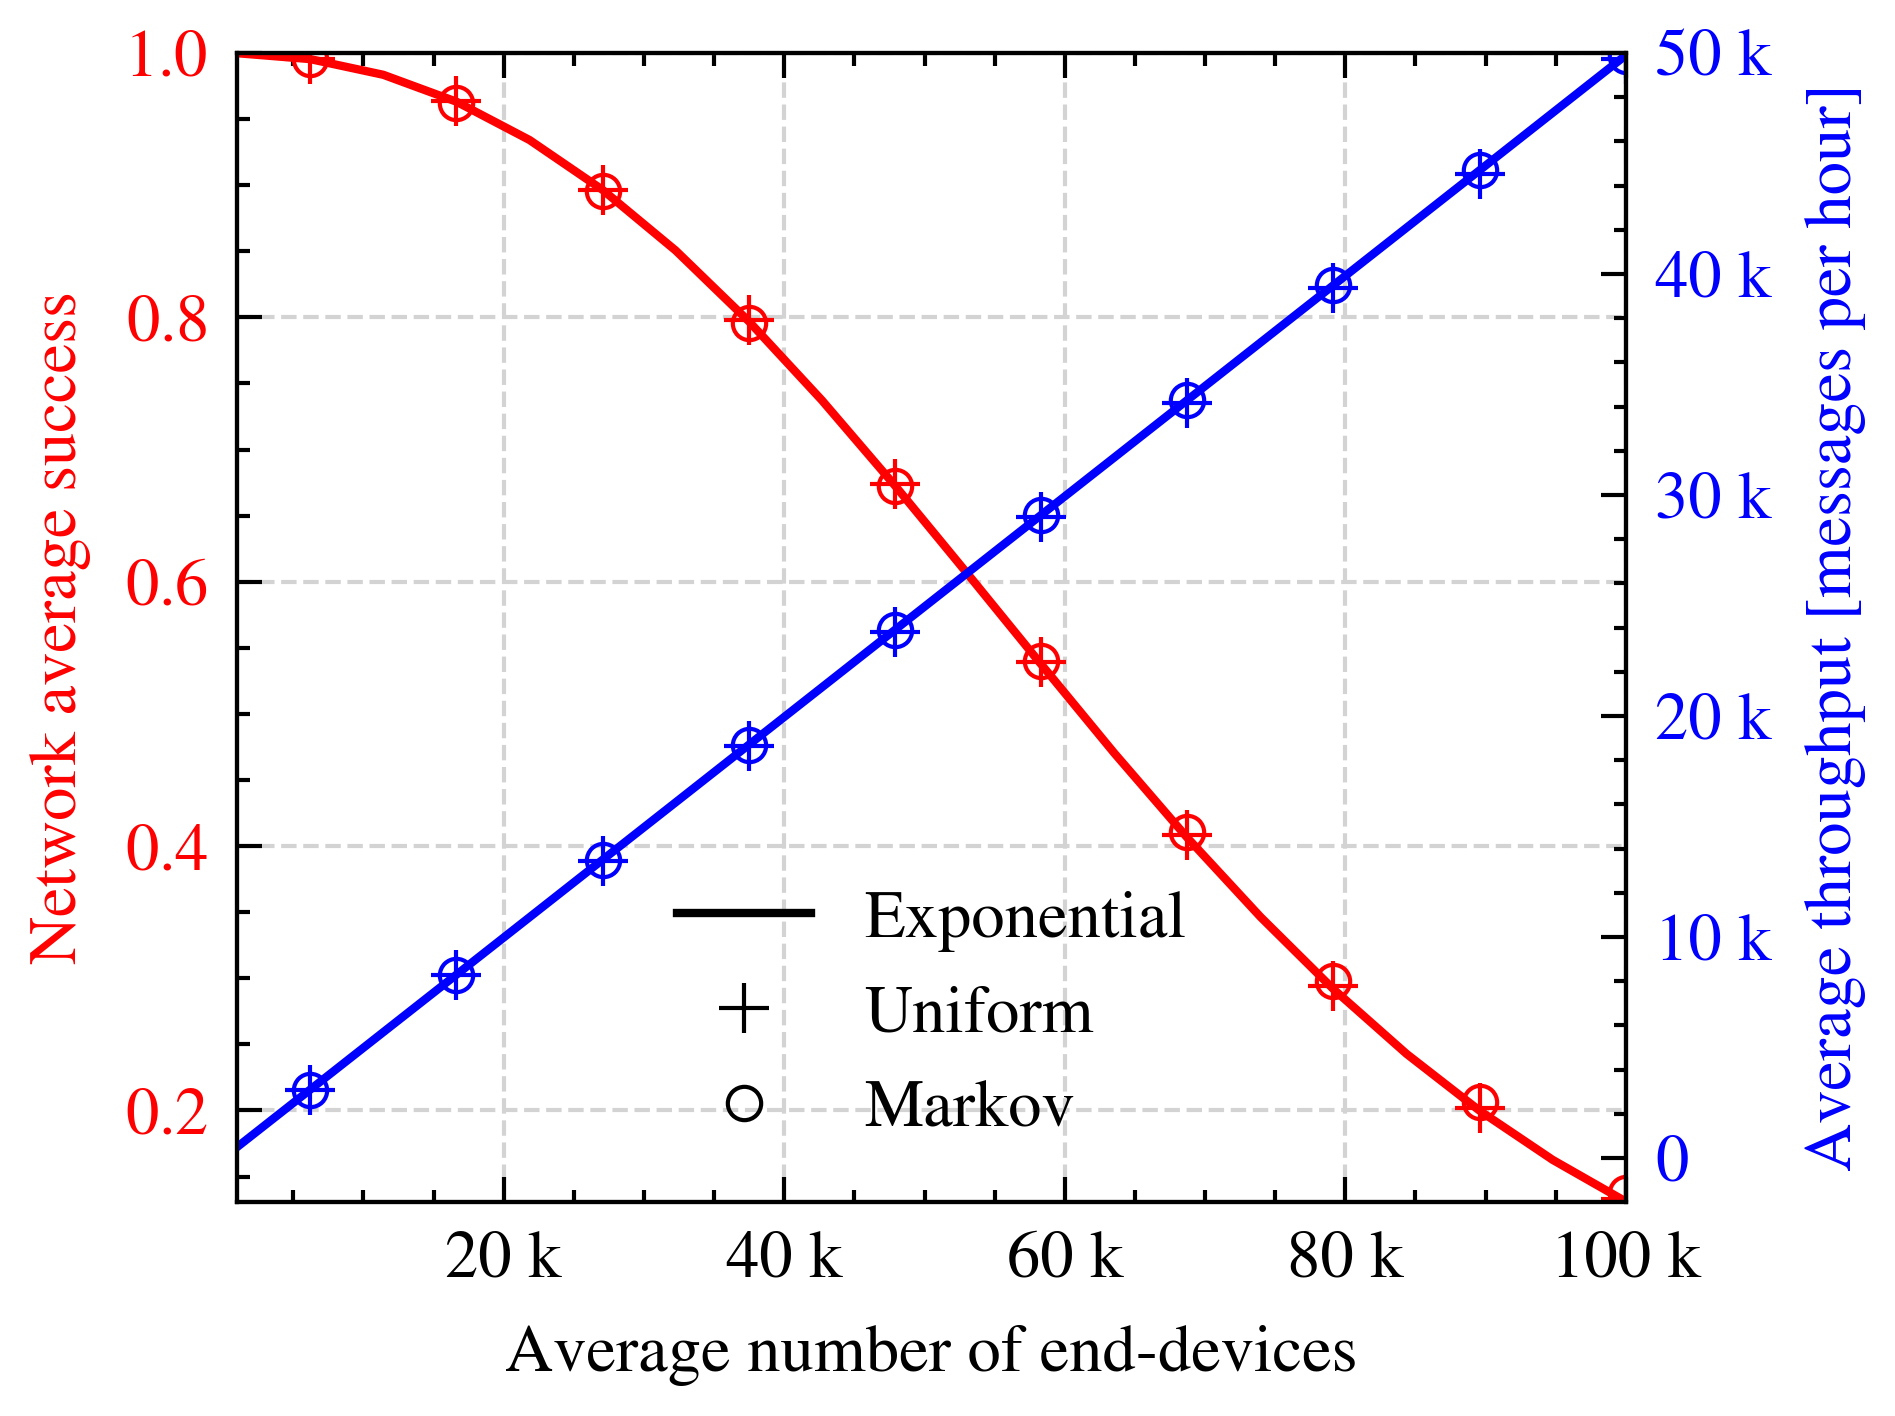

In [20]:
df = pd.read_pickle('example_traffic_1.data.data')
nNodes_points = 20
nNodes_min = 1000
nNodes_max = 100_000
nNodes = np.linspace(nNodes_min, nNodes_max, nNodes_points, dtype=int)//8

f_x = EngFormatter()
f_y = EngFormatter()
with plt.style.context(['science', 'ieee', 'no-latex']):
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    pparam = dict(xlabel='Average number of end-devices')
    fig, ax = plt.subplots()
    ax.xaxis.set_major_formatter(f_x)
    ax.plot(nNodes*8, df['Success'].iloc[0],'-', color=colors[1], label='Exponential')
    ax.plot(nNodes[1::2]*8, df['Success'].iloc[1][1::2],linestyle='None',marker='+', fillstyle='none', markeredgewidth=0.5, color=colors[1], label='Uniform')
    ax.plot(nNodes[1::2]*8, df['Success'].iloc[2][1::2],linestyle='None',marker='o', fillstyle='none', markeredgewidth=0.5,markersize=4,color=colors[1], label='Markov')
    ax.tick_params(axis='y', labelcolor=colors[1])
    leg = ax.legend(loc=8)
    leg.legend_handles[0].set_color('black')
    leg.legend_handles[1].set_color('black')
    leg.legend_handles[2].set_color('black')

    ax.grid(ls='--', color='lightgray')
    ax.autoscale(tight=True)
    ax.set_ylim(top=1)
    ax.set(**pparam)
    ax.set_ylabel('Network average success', color=colors[1])
    ax2= ax.twinx()
    ax2.set_ylabel('Average throughput [messages per hour]', color=colors[2])
    ax2.plot(nNodes*8, np.array(df['Throughput'].iloc[0])/24,'-',  color=colors[2], label='Exponential')
    ax2.plot(nNodes[1::2]*8, np.array(df['Throughput'].iloc[1][1::2])/24,linestyle='None',marker='+', fillstyle='none', markeredgewidth=0.5, color=colors[2], label='Uniform')
    ax2.plot(nNodes[1::2]*8, np.array(df['Throughput'].iloc[2][1::2])/24, linestyle='None',marker='o', fillstyle='none', markeredgewidth=0.5,markersize=4,color=colors[2], label='Markov')
    ax2.set_ylim(top=50000)
    ax2.set_xlim([1000, 100000])
    ax2.tick_params(axis='y', labelcolor=colors[2])
    ax2.yaxis.set_major_formatter(f_y)
    plt.tight_layout()
    plt.show()
    fig.savefig('success_throughput.pdf', dpi=300)
    plt.close()

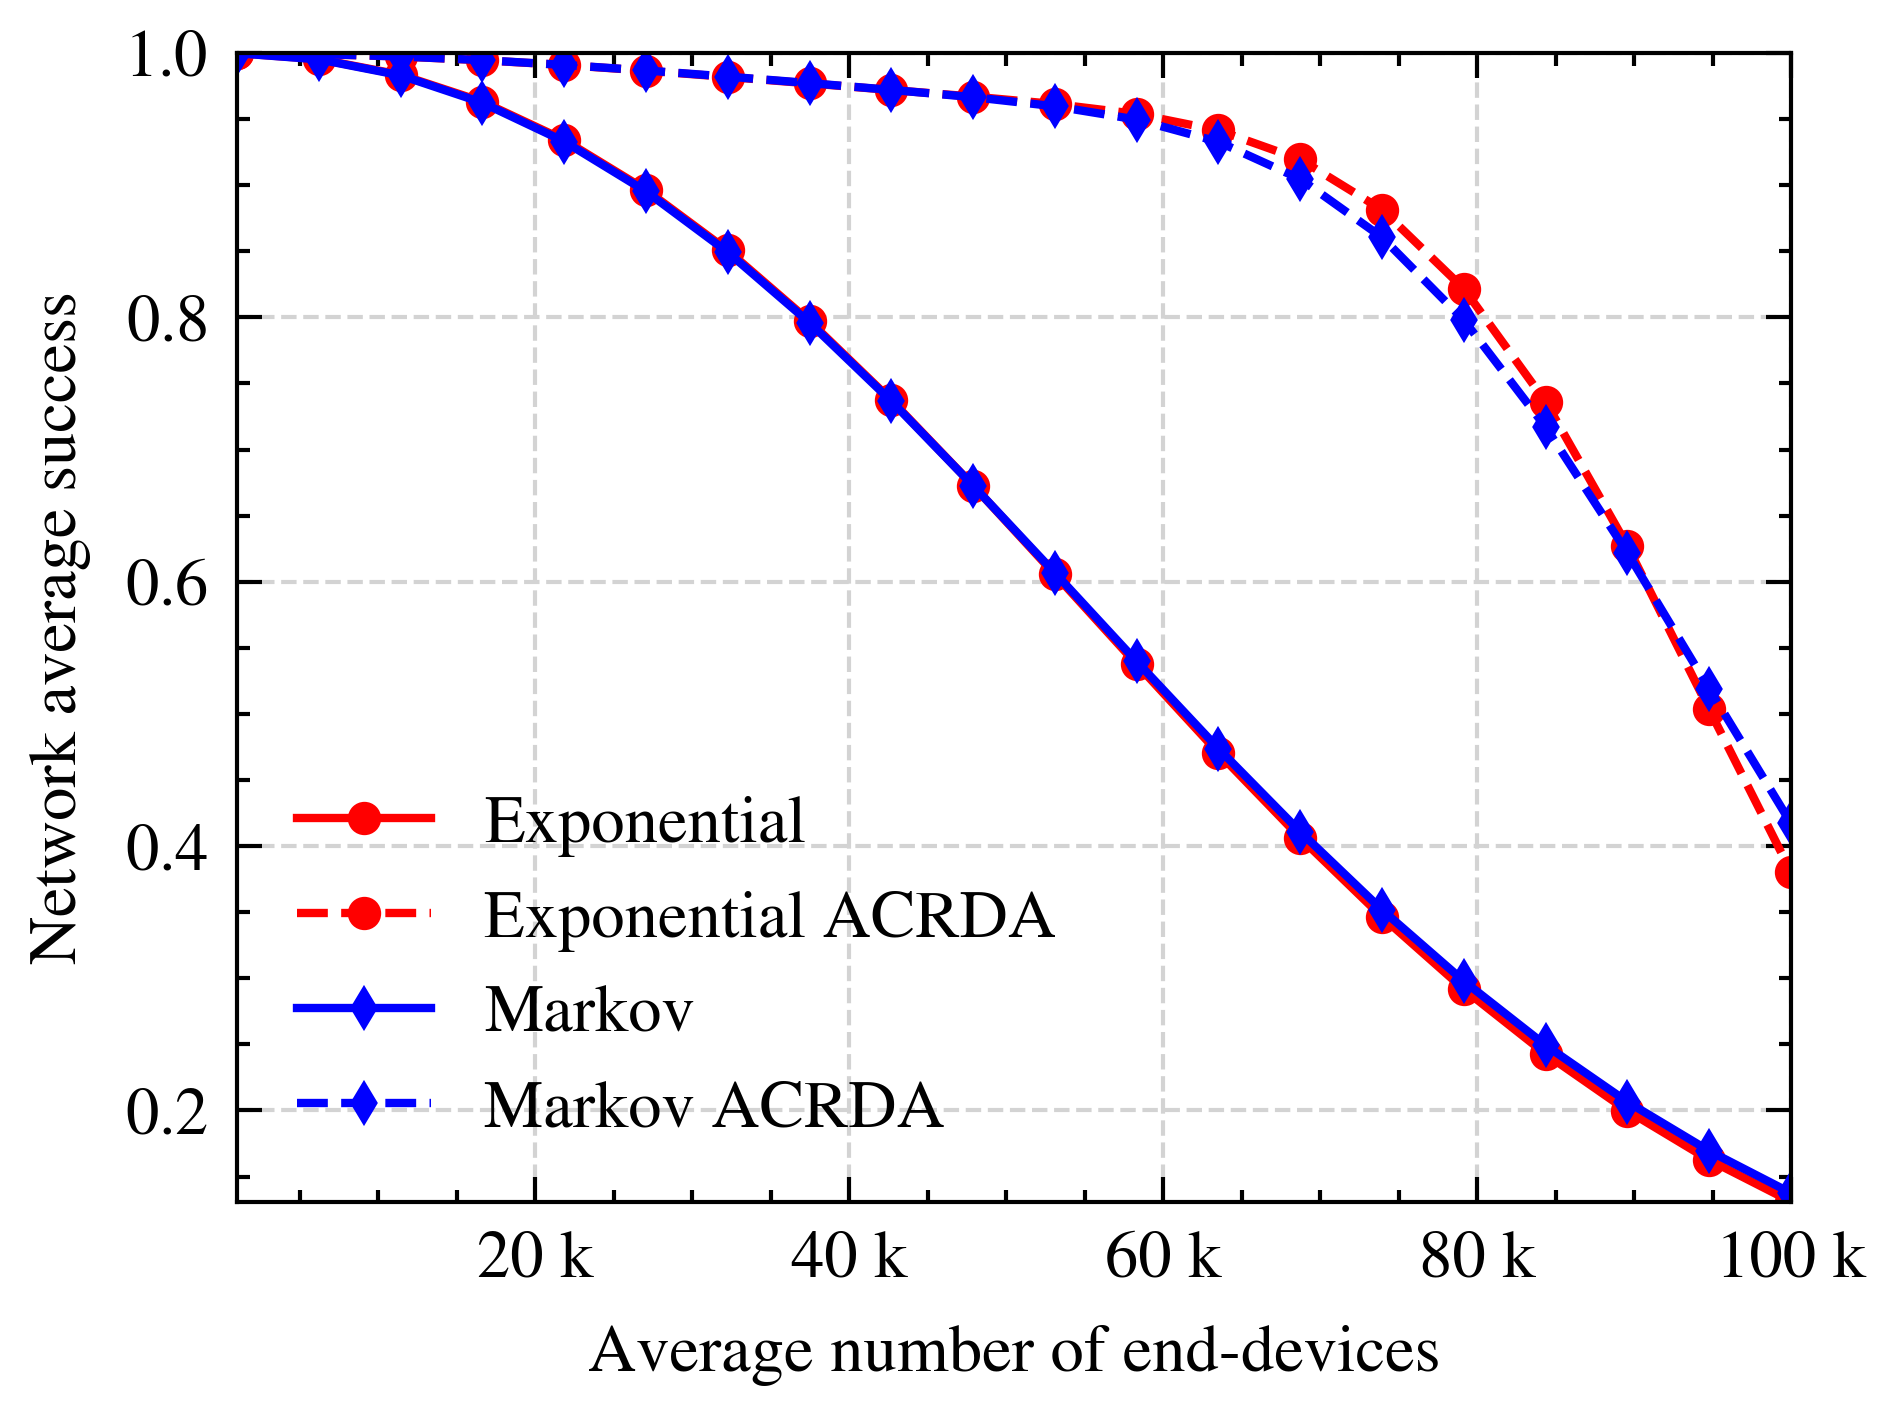

In [19]:
df = pd.read_pickle('example_traffic_1.data.data')
nNodes_points = 20
nNodes_min = 1000
nNodes_max = 100_000
nNodes = np.linspace(nNodes_min, nNodes_max, nNodes_points, dtype=int)//8

f_x = EngFormatter()
with plt.style.context(['science', 'ieee', 'no-latex']):
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    pparam = dict(ylabel='Network average success',xlabel='Average number of end-devices')
    fig, ax = plt.subplots()
    ax.xaxis.set_major_formatter(f_x)
    ax.plot(nNodes*8, df['Success'].iloc[0],'-o', markersize=3,color=colors[1], label='Exponential')
    ax.plot(nNodes*8, df['Success_ACRDA'].iloc[0],'--o', markersize=3,color=colors[1], label='Exponential ACRDA')
    ax.plot(nNodes*8, df['Success'].iloc[2],'-d', markersize=2.5,color=colors[2], label='Markov')
    ax.plot(nNodes*8, df['Success_ACRDA'].iloc[2],'--d', markersize=2.5, color=colors[2], label='Markov ACRDA')
    
    leg = ax.legend(loc=3)

    ax.grid(ls='--', color='lightgray')
    ax.autoscale(tight=True)
    ax.set(**pparam)
    ax.set_ylim(top=1)
    plt.tight_layout()
    plt.show()
    fig.savefig('success_ACRDA.pdf', dpi=300)
    plt.close()

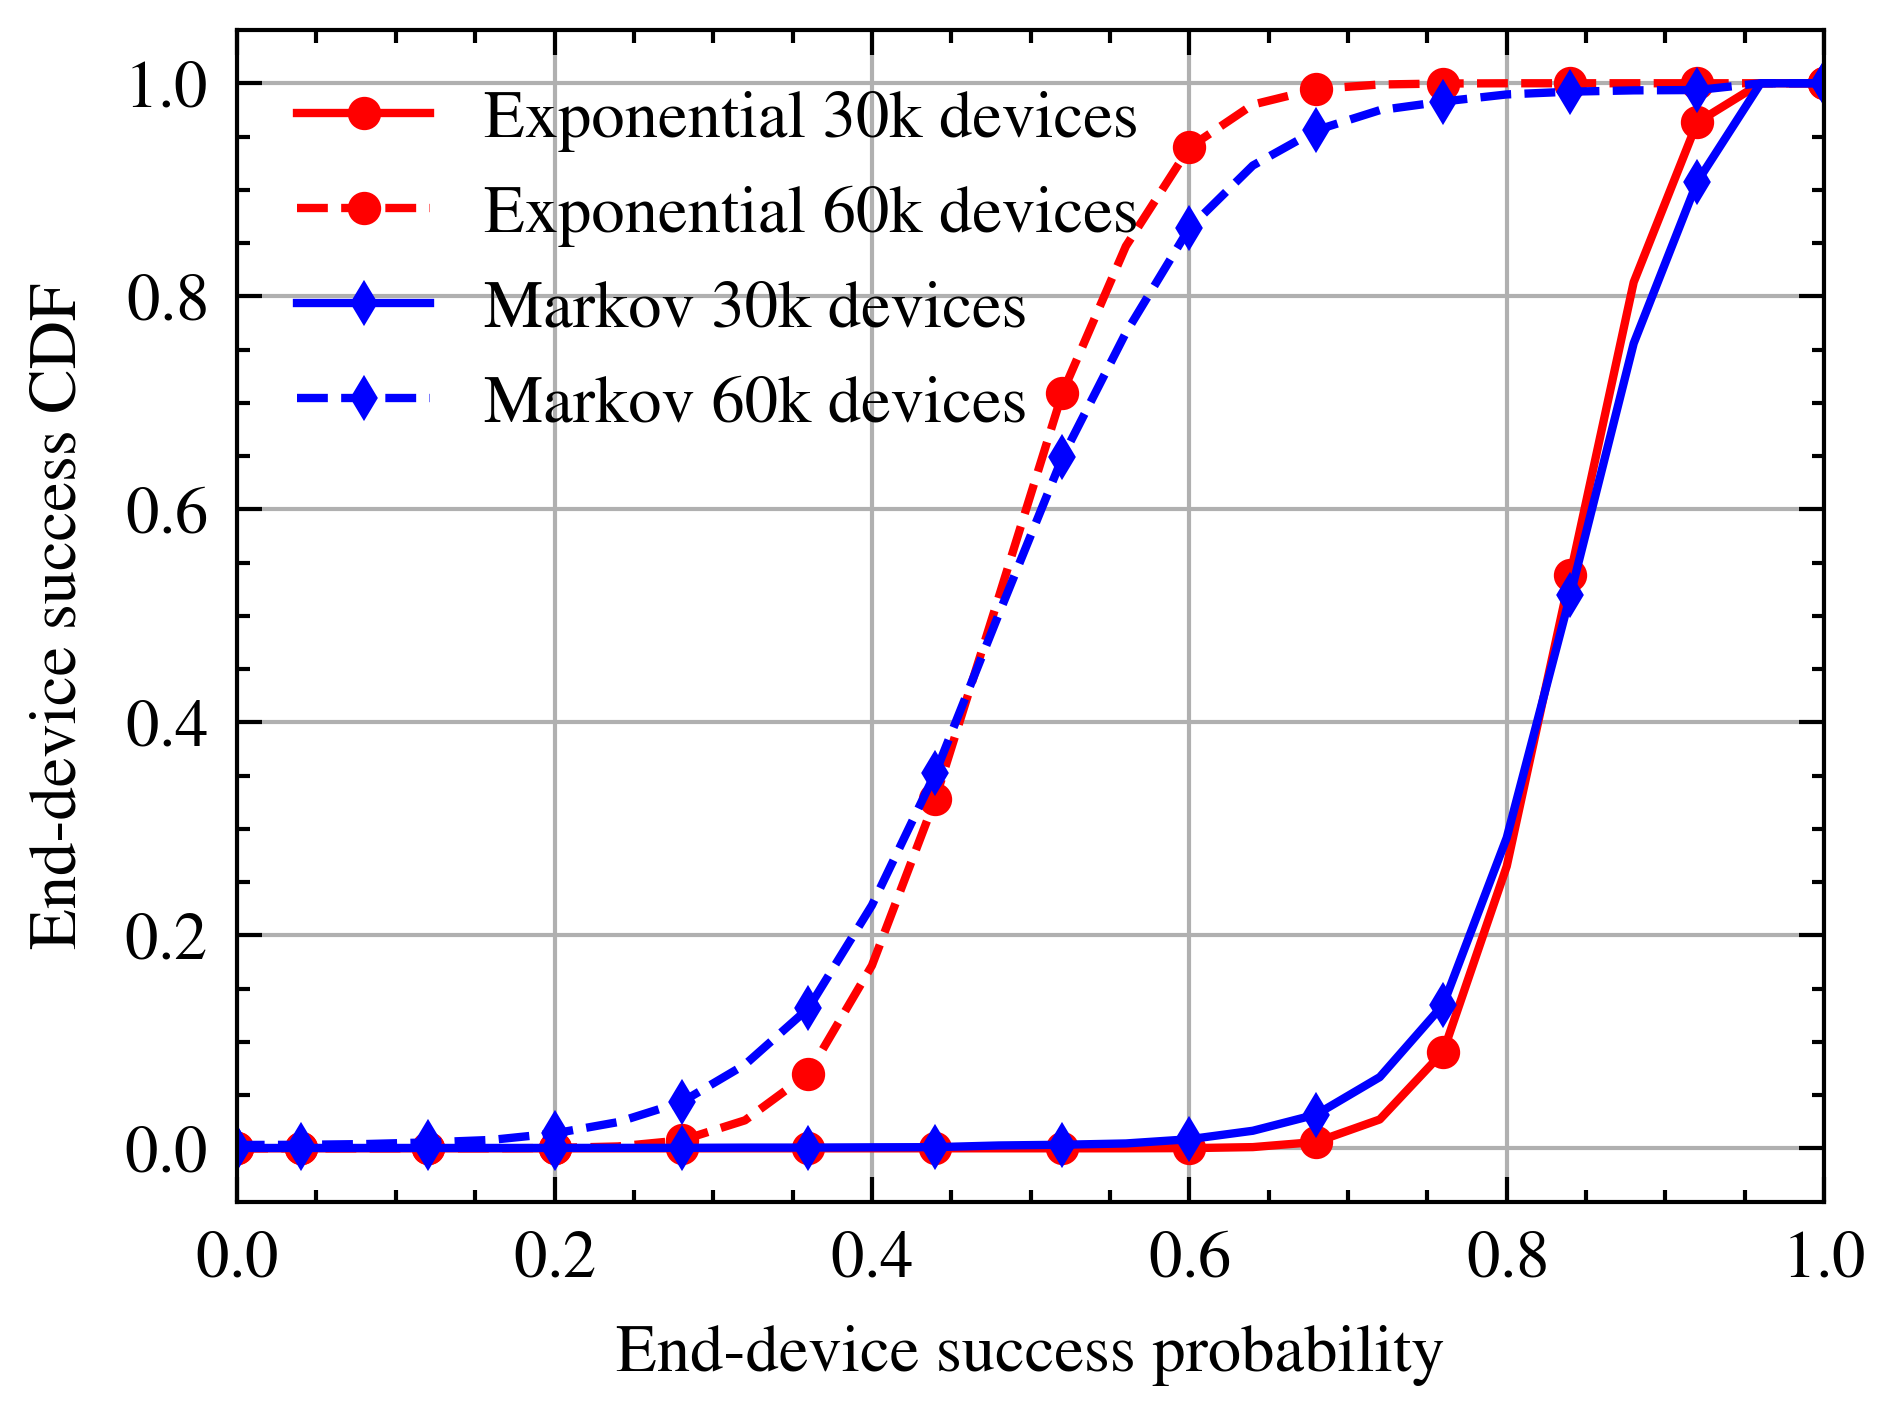

In [18]:
file = open('example_traffic_2.data', 'rb')
received_cdf = pickle.load(file)
file.close()
received_exp = received_cdf[0]
received_markov = received_cdf[1]
f_x = EngFormatter()
f_y = EngFormatter()


with plt.style.context(['science', 'ieee', 'no-latex']):
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    pparam = dict(ylabel='End-device success CDF',xlabel='End-device success probability')
    a = plt.hist(received_exp[0].flatten(), cumulative=True, density=True, bins=25, histtype='step', range=[0, 1], label='Exponential 30k devices');
    b = plt.hist(received_exp[3].flatten(), cumulative=True, density=True, bins=25, histtype='step', range=[0, 1], label='Exponential 60k devices');
    c = plt.hist(received_markov[0].flatten(),cumulative=True, density=True, bins=25, histtype='step', range=[0, 1], label='Markov 30k devices');
    d = plt.hist(received_markov[3].flatten(),cumulative=True, density=True, bins=25, histtype='step', range=[0, 1], label='Markov 60k devices');
    plt.close()

    fig, ax = plt.subplots()

    ax.plot(np.append([0],a[1]), np.append([0], np.append(a[0], 1)),'-o', markersize=3,color='red',label='Exponential 30k devices',markevery=2)
    ax.plot(np.append([0],b[1]), np.append([0], np.append(b[0], 1)),'--o', markersize=3,color='red',label='Exponential 60k devices',markevery=2)
    ax.plot(np.append([0],c[1]), np.append([0], np.append(c[0], 1)),'-d', markersize=2.5,color='blue',label='Markov 30k devices',markevery=2)
    ax.plot(np.append([0],d[1]), np.append([0], np.append(d[0], 1)),'--d', markersize=2.5,color='blue', label='Markov 60k devices',markevery=2)
    plt.xlim([0,1])
    ax.set(**pparam)
    plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.show()
    fig.savefig('CDF.pdf', dpi=300)
    plt.close()